# GPS velocities for the Alpine region

This is a compilation of 3D GPS velocities for the Alps by
[Sánchez et al. (2018)](https://doi.org/10.1594/PANGAEA.886889).
The horizontal velocities are reference to the Eurasian frame. 
All velocity components and even the position have error estimates,
which is very useful and rare to find in a lot of datasets.

Here, we download the data from 3 separate files (coordinates, vertical velocity, horizontal velocities) and make sure they are aligned and represent the same stations. There are some mistakes in the station names of horizontal velocity file that we fix manually (verified by the coordinates).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Download the data

Use Pooch to download and cache the data files.

In [2]:
fname_position = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_NEH.CRD",
    known_hash="sha256:24b88a0e5ab6ea93c67424ef52542d8b8a8254a150284e1a54afddbfd93e4399",
)
fname_velocity = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_NEH.VEL",
    known_hash="sha256:0f2eff87a39260e2b3218897763dbfecdf0f464bf877bef460eff34a70e00aa7",
)
fname_velocity_eurasia = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_REP.VEL",
    known_hash="sha256:578677246230e893c828205391d262da4af39bb24a8ca66ff5a95a88c71fe509",
)

## Load the data

These data are in a strange format and getting pandas to read it would be more work than parsing it by hand. So that's what we're going to do.

First, the horizontal velocities since there are less points and we will only want the vertical and positions of these stations.

In [3]:
station = []
velocity_north_mm_yr = []
velocity_north_error_mm_yr = []
velocity_east_mm_yr = []
velocity_east_error_mm_yr = []
velocity_up_mm_yr = []
velocity_up_error_mm_yr = []
with open(fname_velocity_eurasia, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 19 or not line.strip():
            continue
        columns = line.split()
        station_id = columns[0]
        # Fix these names manually. 
        # They were confirmed by comparing the coordinates.
        if station_id == "CH1Z":
            station_id = "CHIZ"
        if station_id == "IE1G":
            station_id = "IENG"
        values = columns[3:]
        station.append(station_id)
        velocity_east_mm_yr.append(1e3 * float(values[0]))
        velocity_north_mm_yr.append(1e3 * float(values[1]))
        velocity_east_error_mm_yr.append(1e3 * float(values[2]))
        velocity_north_error_mm_yr.append(1e3 * float(values[3]))
# Merge everything into a DataFrame. 
# Use the station ID as the index to help us merge the data later.
data_horizontal = pd.DataFrame(
    data={
        "station_id": station,
        "velocity_east_mmyr": velocity_east_mm_yr,
        "velocity_north_mmyr": velocity_north_mm_yr,
        "velocity_east_error_mmyr": velocity_east_error_mm_yr,
        "velocity_north_error_mmyr": velocity_north_error_mm_yr,
    },
    index=station,
)
data_horizontal

,station_id,velocity_east_mmyr,velocity_north_mmyr,velocity_east_error_mmyr,velocity_north_error_mmyr
ACOM,ACOM,0.2,1.2,0.1,0.1
AFAL,AFAL,-0.7,0.9,0.1,0.2
AGDE,AGDE,-0.2,-0.2,0.1,0.3
AGNE,AGNE,0.0,-0.2,0.2,0.6
AIGL,AIGL,0.0,0.1,0.1,0.5
...,...,...,...,...,...
WLBH,WLBH,0.0,-0.2,0.1,0.2
WTZR,WTZR,0.1,0.2,0.1,0.1
ZADA,ZADA,0.2,3.1,0.2,0.4
ZIMM,ZIMM,-0.1,0.4,0.1,0.1


Now load the position and vertical velocity, keeping only the points that have the horizontal components as well.

In [4]:
station = []
latitude = []
latitude_error_m = []
longitude = []
longitude_error_m = []
height_m = []
height_error_m = []
with open(fname_position, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 15 or i > 304 or not line.strip():
            continue
        columns = line.split()
        if len(columns) == 12:
            station_id = columns[0]
            values = columns[2:8]
        else:
            station_id = columns[0]
            values = columns[1:7]
        # Only interested in the stations that have horizontal
        if station_id not in data_horizontal.station_id:
            continue
        # Skip repeated stations because it's easier this way
        if station_id in station:
            continue
        values = [float(x) for x in values]
        # Make longitude be in [-180, 180] for easier plotting
        if values[2] > 300:
            values[2] -= 360
        station.append(station_id)
        latitude.append(values[0])
        latitude_error_m.append(values[1])
        longitude.append(values[2])
        longitude_error_m.append(values[3])
        height_m.append(values[4])
        height_error_m.append(values[5])
# Merge everything into a DataFrame. 
data_position = pd.DataFrame(
    data={
        "station_id": station,
        "latitude": latitude,
        "longitude": longitude,
        "height_m": height_m,
        "latitude_error_m": latitude_error_m,
        "longitude_error_m": longitude_error_m,
        "height_error_m": height_error_m,
    },
    index=station,
)
data_position

,station_id,latitude,longitude,height_m,latitude_error_m,longitude_error_m,height_error_m
ACOM,ACOM,46.547935,13.514900,1774.682,0.0009,0.0005,0.001
AFAL,AFAL,46.527144,12.174517,2284.085,0.0009,0.0009,0.001
AGDE,AGDE,43.296383,3.466427,65.785,0.0018,0.0009,0.002
AGNE,AGNE,45.467942,7.139620,2354.600,0.0036,0.0009,0.004
AIGL,AIGL,44.121398,3.581261,1618.764,0.0009,0.0009,0.002
...,...,...,...,...,...,...,...
WLBH,WLBH,48.415171,7.351299,819.069,0.0009,0.0005,0.001
WTZR,WTZR,49.144199,12.878911,666.025,0.0005,0.0005,0.001
ZADA,ZADA,44.113177,15.227590,64.307,0.0036,0.0018,0.004
ZIMM,ZIMM,46.877098,7.465278,956.341,0.0009,0.0005,0.001


In [5]:
station = []
velocity_up_mm_yr = []
velocity_up_error_mm_yr = []
with open(fname_velocity, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 15 or i > 303 or not line.strip():
            continue
        columns = line.split()        
        if len(columns) == 12:
            station_id = columns[0]
            values = columns[6:8]
        else:
            station_id = columns[0]
            values = columns[5:7]
        # Only interested in the stations that have horizontal
        if station_id not in data_horizontal.station_id:
            continue
        # Skip repeated stations because it's easier this way
        if station_id in station:
            continue
        station.append(station_id)
        velocity_up_mm_yr.append(1e3 * float(values[0]))
        velocity_up_error_mm_yr.append(1e3 * float(values[1]))
# Merge everything into a DataFrame. 
data_vertical = pd.DataFrame(
    data={
        "station_id": station,
        "velocity_up_mmyr": velocity_up_mm_yr,
        "velocity_up_error_mmyr": velocity_up_error_mm_yr,
    },
    index=station,
)
data_vertical

,station_id,velocity_up_mmyr,velocity_up_error_mmyr
ACOM,ACOM,1.1,0.1
AFAL,AFAL,1.3,0.2
AGDE,AGDE,0.1,0.3
AGNE,AGNE,1.5,0.5
AIGL,AIGL,0.7,0.5
...,...,...,...
WLBH,WLBH,-2.8,0.2
WTZR,WTZR,-0.1,0.1
ZADA,ZADA,-0.3,0.4
ZIMM,ZIMM,1.0,0.1


Merge all of the DataFrames into a single one.

In [6]:
data = pd.merge(pd.merge(data_horizontal, data_vertical), data_position)
data

,station_id,velocity_east_mmyr,velocity_north_mmyr,velocity_east_error_mmyr,velocity_north_error_mmyr,velocity_up_mmyr,velocity_up_error_mmyr,latitude,longitude,height_m,latitude_error_m,longitude_error_m,height_error_m
0,ACOM,0.2,1.2,0.1,0.1,1.1,0.1,46.547935,13.514900,1774.682,0.0009,0.0005,0.001
1,AFAL,-0.7,0.9,0.1,0.2,1.3,0.2,46.527144,12.174517,2284.085,0.0009,0.0009,0.001
2,AGDE,-0.2,-0.2,0.1,0.3,0.1,0.3,43.296383,3.466427,65.785,0.0018,0.0009,0.002
3,AGNE,0.0,-0.2,0.2,0.6,1.5,0.5,45.467942,7.139620,2354.600,0.0036,0.0009,0.004
4,AIGL,0.0,0.1,0.1,0.5,0.7,0.5,44.121398,3.581261,1618.764,0.0009,0.0009,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,0.0,-0.2,0.1,0.2,-2.8,0.2,48.415171,7.351299,819.069,0.0009,0.0005,0.001
182,WTZR,0.1,0.2,0.1,0.1,-0.1,0.1,49.144199,12.878911,666.025,0.0005,0.0005,0.001
183,ZADA,0.2,3.1,0.2,0.4,-0.3,0.4,44.113177,15.227590,64.307,0.0036,0.0018,0.004
184,ZIMM,-0.1,0.4,0.1,0.1,1.0,0.1,46.877098,7.465278,956.341,0.0009,0.0005,0.001


## Plot the data

Make a quick plot of the data to see if it looks the same as the paper figures.

In [7]:
angle = np.degrees(np.arctan2(data.velocity_north_mmyr, data.velocity_east_mmyr))
length = np.hypot(data.velocity_north_mmyr, data.velocity_east_mmyr)

In [8]:
region = vd.pad_region(vd.get_region((data.longitude, data.latitude)), pad=1)

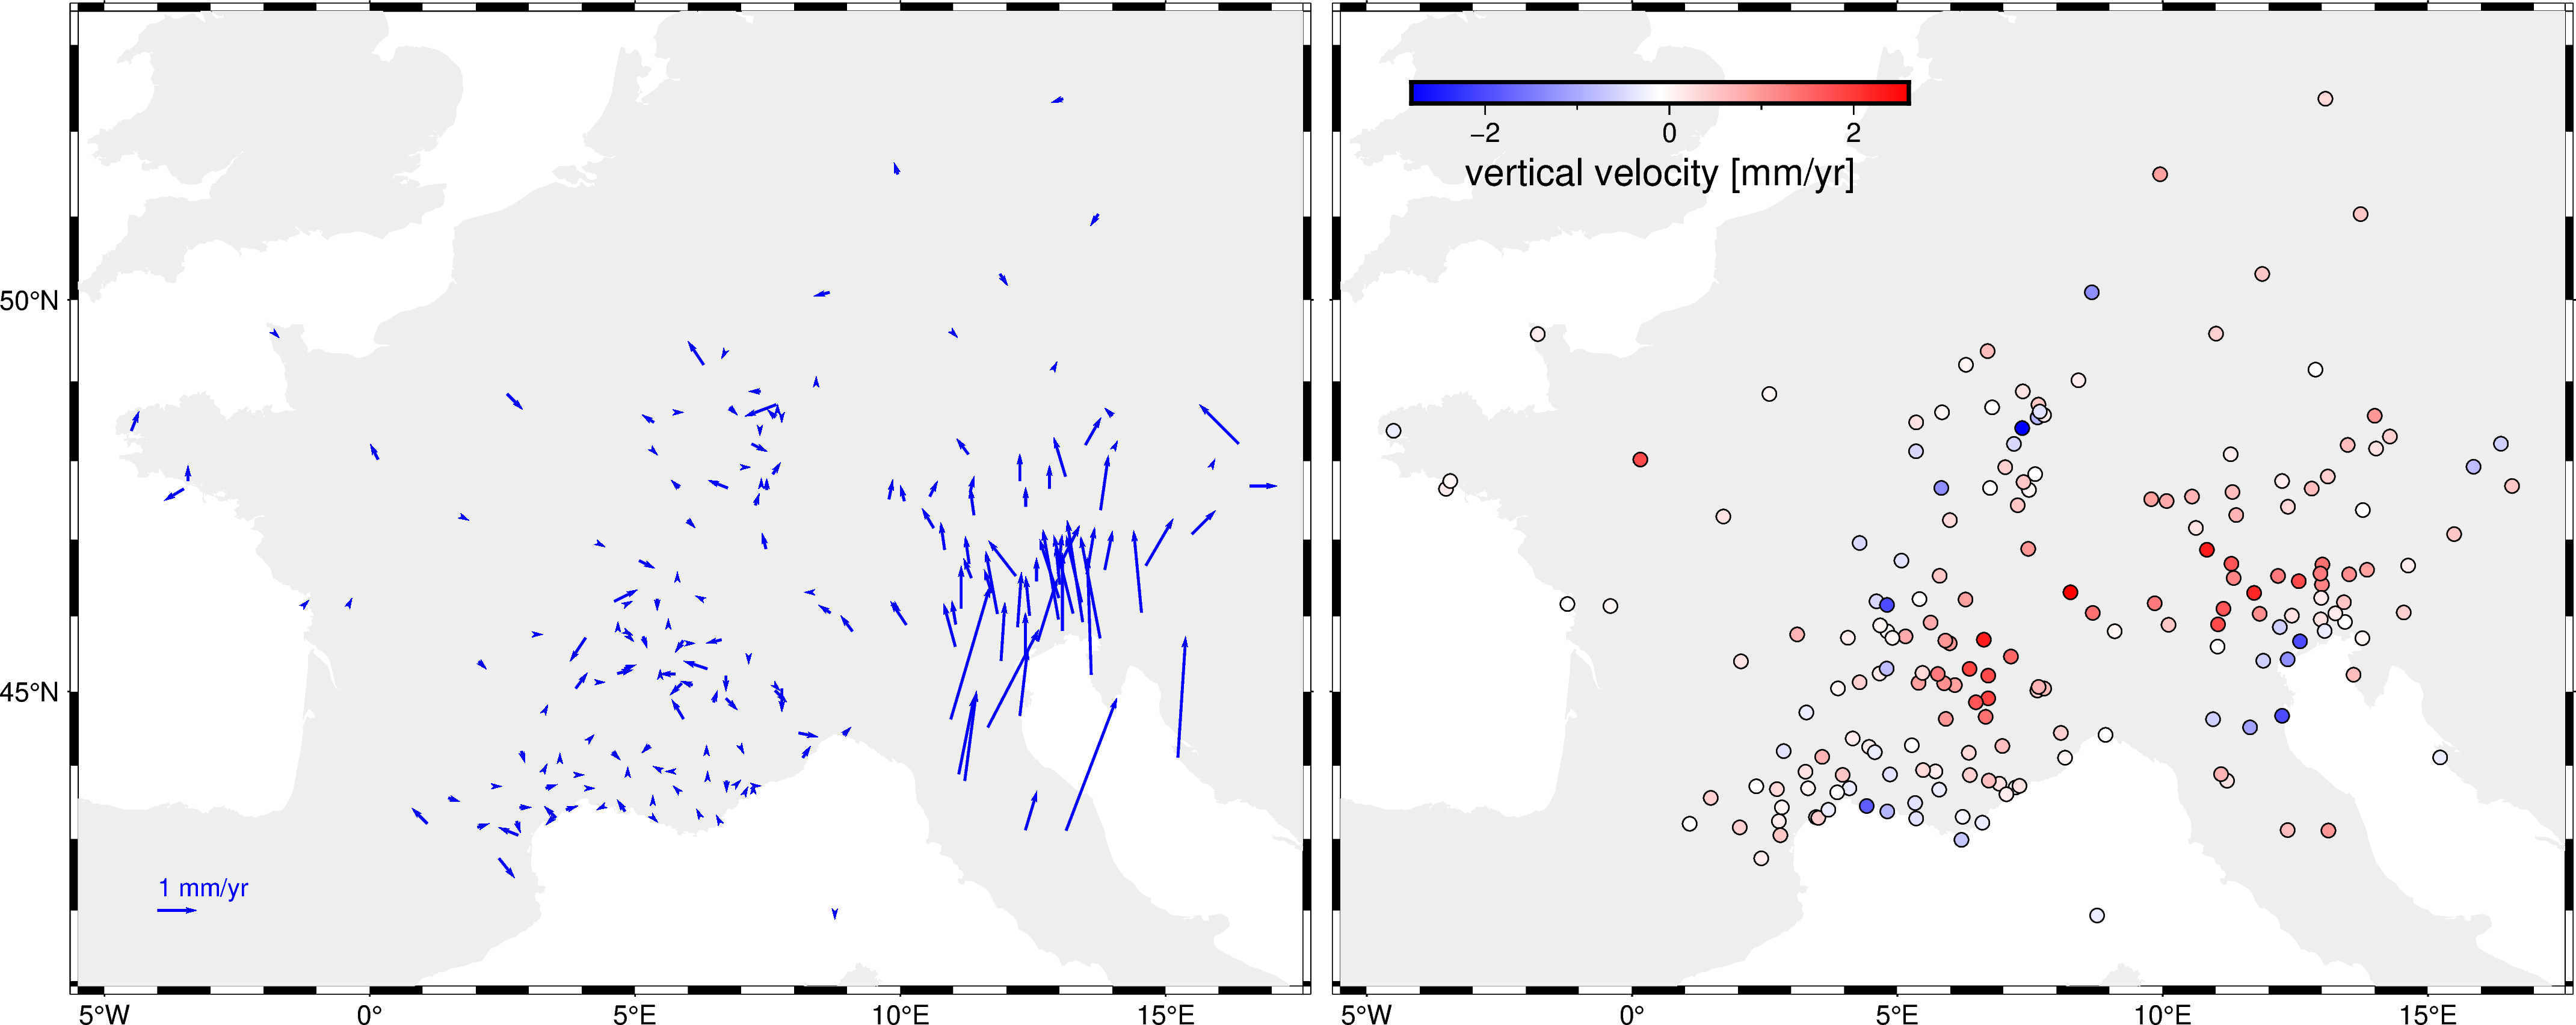

In [9]:
fig = pygmt.Figure()
with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("35c", "15c"),
    sharey="l",  # shared y-axis on the left side
    frame="WSrt",
):
    with fig.set_panel(0):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")        
        scale_factor = 2 / length.max()
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            direction=[angle, length * scale_factor],
            style="v0.15c+e",
            color="blue",
            pen="1p,blue",
        )    
        # Plot a quiver caption
        fig.plot(
            x=-4,
            y=42,
            direction=[[0], [1 * scale_factor]],
            style="v0.15c+e",
            color="blue",
            pen="1p,blue",
        )
        fig.text(
            x=-4,
            y=42.2,
            text=f"1 mm/yr",
            justify="BL",
            font="10p,Helvetica,blue",
        )
    with fig.set_panel(1):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")
        pygmt.makecpt(cmap="polar", series=[data.velocity_up_mmyr.min(), data.velocity_up_mmyr.max()])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            color=data.velocity_up_mmyr,
            style="c0.2c",
            cmap=True,
            pen="0.5p,black",
        )
        fig.colorbar(
            frame='af+l"vertical velocity [mm/yr]"',
            position="jTL+w7c/0.3c+h+o1/1",
        )
fig.show(width=1000)

This looks very similar to the plots in [Sánchez et al. (2018)](https://doi.org/10.5194/essd-10-1503-2018).

In [10]:
data

,station_id,velocity_east_mmyr,velocity_north_mmyr,velocity_east_error_mmyr,velocity_north_error_mmyr,velocity_up_mmyr,velocity_up_error_mmyr,latitude,longitude,height_m,latitude_error_m,longitude_error_m,height_error_m
0,ACOM,0.2,1.2,0.1,0.1,1.1,0.1,46.547935,13.514900,1774.682,0.0009,0.0005,0.001
1,AFAL,-0.7,0.9,0.1,0.2,1.3,0.2,46.527144,12.174517,2284.085,0.0009,0.0009,0.001
2,AGDE,-0.2,-0.2,0.1,0.3,0.1,0.3,43.296383,3.466427,65.785,0.0018,0.0009,0.002
3,AGNE,0.0,-0.2,0.2,0.6,1.5,0.5,45.467942,7.139620,2354.600,0.0036,0.0009,0.004
4,AIGL,0.0,0.1,0.1,0.5,0.7,0.5,44.121398,3.581261,1618.764,0.0009,0.0009,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,0.0,-0.2,0.1,0.2,-2.8,0.2,48.415171,7.351299,819.069,0.0009,0.0005,0.001
182,WTZR,0.1,0.2,0.1,0.1,-0.1,0.1,49.144199,12.878911,666.025,0.0005,0.0005,0.001
183,ZADA,0.2,3.1,0.2,0.4,-0.3,0.4,44.113177,15.227590,64.307,0.0036,0.0018,0.004
184,ZIMM,-0.1,0.4,0.1,0.1,1.0,0.1,46.877098,7.465278,956.341,0.0009,0.0005,0.001


## Export

Save the data to a compressed CSV.

In [11]:
export = pd.DataFrame({
    "station_id": data.station_id,
    "longitude": data.longitude.map(lambda x: "{:.7f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.7f}".format(x)),    
    "height_m": data.height_m.map(lambda x: "{:.3f}".format(x)),
    "velocity_east_mmyr": data.velocity_east_mmyr.map(lambda x: "{:.1f}".format(x)),
    "velocity_north_mmyr": data.velocity_north_mmyr.map(lambda x: "{:.1f}".format(x)),
    "velocity_up_mmyr": data.velocity_up_mmyr.map(lambda x: "{:.1f}".format(x)),
    "longitude_error_m": data.longitude_error_m.map(lambda x: "{:.4f}".format(x)),
    "latitude_error_m": data.latitude_error_m.map(lambda x: "{:.4f}".format(x)),
    "height_error_m": data.height_error_m.map(lambda x: "{:.3f}".format(x)),
    "velocity_east_error_mmyr": data.velocity_east_error_mmyr.map(lambda x: "{:.1f}".format(x)),
    "velocity_north_error_mmyr": data.velocity_north_error_mmyr.map(lambda x: "{:.1f}".format(x)),
    "velocity_up_error_mmyr": data.velocity_up_error_mmyr.map(lambda x: "{:.1f}".format(x)),
})
export

,station_id,longitude,latitude,height_m,velocity_east_mmyr,velocity_north_mmyr,velocity_up_mmyr,longitude_error_m,latitude_error_m,height_error_m,velocity_east_error_mmyr,velocity_north_error_mmyr,velocity_up_error_mmyr
0,ACOM,13.5149004,46.5479352,1774.682,0.2,1.2,1.1,0.0005,0.0009,0.001,0.1,0.1,0.1
1,AFAL,12.1745170,46.5271440,2284.085,-0.7,0.9,1.3,0.0009,0.0009,0.001,0.1,0.2,0.2
2,AGDE,3.4664272,43.2963831,65.785,-0.2,-0.2,0.1,0.0009,0.0018,0.002,0.1,0.3,0.3
3,AGNE,7.1396203,45.4679419,2354.600,0.0,-0.2,1.5,0.0009,0.0036,0.004,0.2,0.6,0.5
4,AIGL,3.5812609,44.1213985,1618.764,0.0,0.1,0.7,0.0009,0.0009,0.002,0.1,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,7.3512992,48.4151715,819.069,0.0,-0.2,-2.8,0.0005,0.0009,0.001,0.1,0.2,0.2
182,WTZR,12.8789111,49.1441992,666.025,0.1,0.2,-0.1,0.0005,0.0005,0.001,0.1,0.1,0.1
183,ZADA,15.2275901,44.1131766,64.307,0.2,3.1,-0.3,0.0018,0.0036,0.004,0.2,0.4,0.4
184,ZIMM,7.4652781,46.8770983,956.341,-0.1,0.4,1.0,0.0005,0.0009,0.001,0.1,0.1,0.1


In [12]:
fname = "alps-gps-velocity.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

alps-gps-velocity.csv.xz
size: 0.004544 Mb
md5:195ee3d88783ce01b6190c2af89f2b14
sha256:77f2907c2a019366e5f85de5aafcab2d0e90cc2c378171468a7705cab9938584


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [13]:
gps = pd.read_csv(fname)
gps

,station_id,longitude,latitude,height_m,velocity_east_mmyr,velocity_north_mmyr,velocity_up_mmyr,longitude_error_m,latitude_error_m,height_error_m,velocity_east_error_mmyr,velocity_north_error_mmyr,velocity_up_error_mmyr
0,ACOM,13.514900,46.547935,1774.682,0.2,1.2,1.1,0.0005,0.0009,0.001,0.1,0.1,0.1
1,AFAL,12.174517,46.527144,2284.085,-0.7,0.9,1.3,0.0009,0.0009,0.001,0.1,0.2,0.2
2,AGDE,3.466427,43.296383,65.785,-0.2,-0.2,0.1,0.0009,0.0018,0.002,0.1,0.3,0.3
3,AGNE,7.139620,45.467942,2354.600,0.0,-0.2,1.5,0.0009,0.0036,0.004,0.2,0.6,0.5
4,AIGL,3.581261,44.121398,1618.764,0.0,0.1,0.7,0.0009,0.0009,0.002,0.1,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,7.351299,48.415171,819.069,0.0,-0.2,-2.8,0.0005,0.0009,0.001,0.1,0.2,0.2
182,WTZR,12.878911,49.144199,666.025,0.1,0.2,-0.1,0.0005,0.0005,0.001,0.1,0.1,0.1
183,ZADA,15.227590,44.113177,64.307,0.2,3.1,-0.3,0.0018,0.0036,0.004,0.2,0.4,0.4
184,ZIMM,7.465278,46.877098,956.341,-0.1,0.4,1.0,0.0005,0.0009,0.001,0.1,0.1,0.1


In [14]:
projection = pyproj.Proj(proj="merc", lat_ts=gps.latitude.mean())
easting, northing = projection(gps.longitude, gps.latitude)

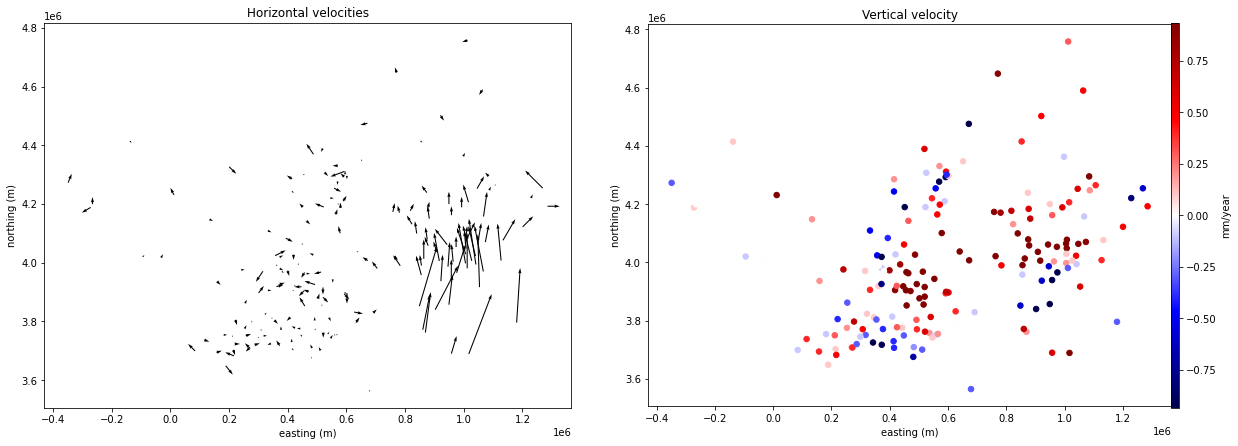

In [15]:
fig, axes = plt.subplots(
    1, 2, figsize=(18, 6)
)
# Plot the horizontal velocity vectors
ax = axes[0]
ax.set_title("Horizontal velocities")
ax.quiver(
    easting, northing,
    gps.velocity_east_mmyr.values,
    gps.velocity_north_mmyr.values,
    scale=30,
    width=0.002,
)
ax.set_aspect("equal")
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
# Plot the vertical velocity
ax = axes[1]
ax.set_title("Vertical velocity")
maxabs = vd.maxabs(gps.velocity_up_mmyr)
tmp = ax.scatter(
    easting, northing,
    c=gps.velocity_up_mmyr,
    s=30,
    vmin=-maxabs / 3,
    vmax=maxabs / 3,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax, label="mm/year", pad=0, aspect=50)
ax.set_aspect("equal")
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
plt.tight_layout(pad=0)
plt.show()